In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from scipy.spatial.transform import Rotation as R
import pandas as pd
import json
from tqdm import tqdm
import random
import mujoco
import pickle

MODEL_DIR = "/common/home/dm1487/robotics_research/ktamp/ml4kp_ktamp/resources/models/custom_walled_envs/jun17/random_start_random_goal_room_2_50k"

In [18]:
def get_geom_sizes(config_name):
    model = mujoco.MjModel.from_xml_path(f"{MODEL_DIR}/{config_name}.xml")
    # Get all geom information
    geom_sizes = {}
    for i in range(model.ngeom):
        # Get geom name
        geom_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_GEOM, i)
        if geom_name is None:
            geom_name = f"geom_{i}"
        geom_sizes[geom_name] = model.geom_size[i]
    
    del model
    return geom_sizes

create_rectange = lambda x, y, angle, w, h, color: Rectangle((x-w, y-h), w*2, h*2, angle=angle*180/np.pi, fill=True, color=color, rotation_point='center')
create_circle = lambda x, y, r, color: Circle((x, y), r, color=color)

DATA_DIR = "/common/users/dm1487/namo_data/jun17/random_start_random_goal_room_2_50k"

datafiles = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith(".json")]

In [19]:
from collections import Counter
dp_counts = []
for datafile in tqdm(datafiles):
    with open(datafile, "r") as f:
        tmp_data = json.load(f)
    dp_counts.append(len(tmp_data['data_points'])-1)
counts = Counter(dp_counts)

100%|██████████| 260/260 [00:00<00:00, 975.32it/s]


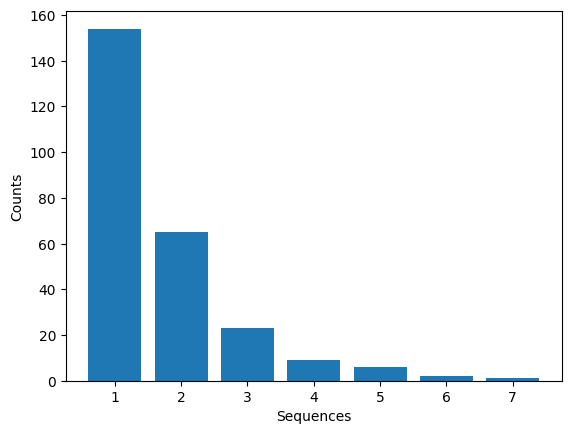

In [20]:
# Method 2: With explicit positioning and labels
categories = list(counts.keys())
values = list(counts.values())

plt.bar(categories, values)
plt.xticks(categories)  # Ensure all categories are shown
plt.xlabel("Sequences")
plt.ylabel("Counts")
# plt.title("")
plt.show()


/common/users/dm1487/namo_data/jun17/random_start_random_goal_room_2_50k/sequence_20250618_051255_a7a363_env_config_27477_iter5_20250618_051939_ilab2.cs.rutgers.edu_0.json


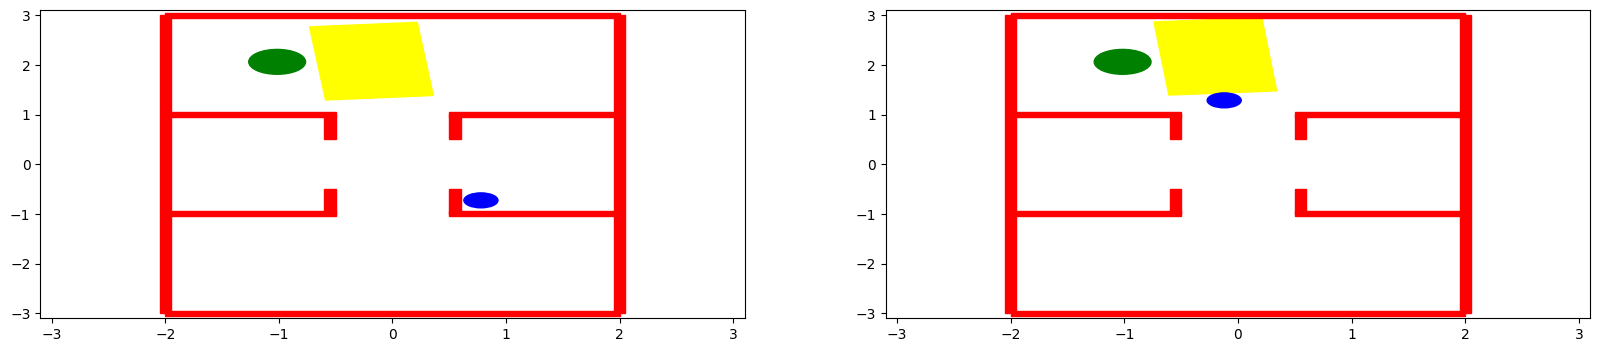

In [31]:
random.shuffle(datafiles)
dp_counts = {}
# for datafile in datafiles[:1]:
for datafile in datafiles[:1]:
    print(datafile)
    with open(datafile, "r") as f:
        data = json.load(f)
config_name = data['config_name']
data_points = data['data_points']

geom_sizes = get_geom_sizes(data['config_name'])
fig, ax = plt.subplots(1, len(data_points), figsize=(20, 4))
for idx, dp in enumerate(data['data_points']):
    for objects, info in dp['state']['objects'].items():
        if objects in geom_sizes:
            color = 'red'
            if "movable" in objects:
                color = 'yellow'
            rect_patch = create_rectange(*info['position'][:2], R.from_quat(info['quaternion'], scalar_first=True).as_euler('xyz')[-1], *geom_sizes[objects][:2], color)
            ax[idx].add_patch(rect_patch)
            
    circle_patch = create_circle(*dp['state']['robot']['position'][:2], 0.15, 'blue')
    ax[idx].add_patch(circle_patch)
    circle_patch = create_circle(*data['robot_goal'], 0.25, 'green')
    ax[idx].add_patch(circle_patch)
    ax[idx].set_xlim(-3.1, 3.1)
    ax[idx].set_ylim(-3.1, 3.1)
plt.show()

## Extracting the best of the data files

In [206]:
from_file = True

if from_file:
    with open('/common/users/dm1487/namo_data/may5_random_start_random_goal_many_env.pkl', 'rb') as f:
        final_datafiles = pickle.load(f)
else:
    by_config_name = {}
    for datafile in tqdm(datafiles):
        config_name = "env_config_" + datafile.split('env_config_')[-1].split('_')[0]
        if config_name not in by_config_name:
            by_config_name[config_name] = [500]
        with open(datafile, "r") as f:
            data = json.load(f)
        if len(data['data_points']) < by_config_name[config_name][0]:
            by_config_name[config_name] = [len(data['data_points']), datafile]
        elif len(data['data_points']) == by_config_name[config_name][0]:
            by_config_name[config_name].append(datafile)
        
    final_datafiles = []    
    for by_config_name in by_config_name.values():
        final_datafiles.extend(by_config_name[1:])
    final_datafiles

# import pickle
# with open('/common/users/dm1487/namo_data/may5_random_start_random_goal_many_env.pkl', 'wb') as f:
#     pickle.dump(final_datafiles, f)

/common/users/dm1487/namo_data/jun2/random_start_random_goal_many_env/sequence_20250602_172454_18a971_env_config_1342_iter0_20250605_213816_ilab1.cs.rutgers.edu_0.json
/common/users/dm1487/namo_data/jun2/random_start_random_goal_many_env/sequence_20250602_172454_18a971_env_config_1342_iter6_20250606_023321_ilab1.cs.rutgers.edu_0.json
/common/users/dm1487/namo_data/jun2/random_start_random_goal_many_env/sequence_20250602_172454_18a971_env_config_1342_iter9_20250606_002445_ilab1.cs.rutgers.edu_0.json
/common/users/dm1487/namo_data/jun2/random_start_random_goal_many_env/sequence_20250602_172454_18a971_env_config_1342_iter7_20250605_061733_ilab1.cs.rutgers.edu_0.json
/common/users/dm1487/namo_data/jun2/random_start_random_goal_many_env/sequence_20250602_172454_18a971_env_config_1342_iter4_20250605_055610_ilab1.cs.rutgers.edu_0.json
/common/users/dm1487/namo_data/jun2/random_start_random_goal_many_env/sequence_20250602_172454_18a971_env_config_1342_iter2_20250604_074042_ilab1.cs.rutgers.edu

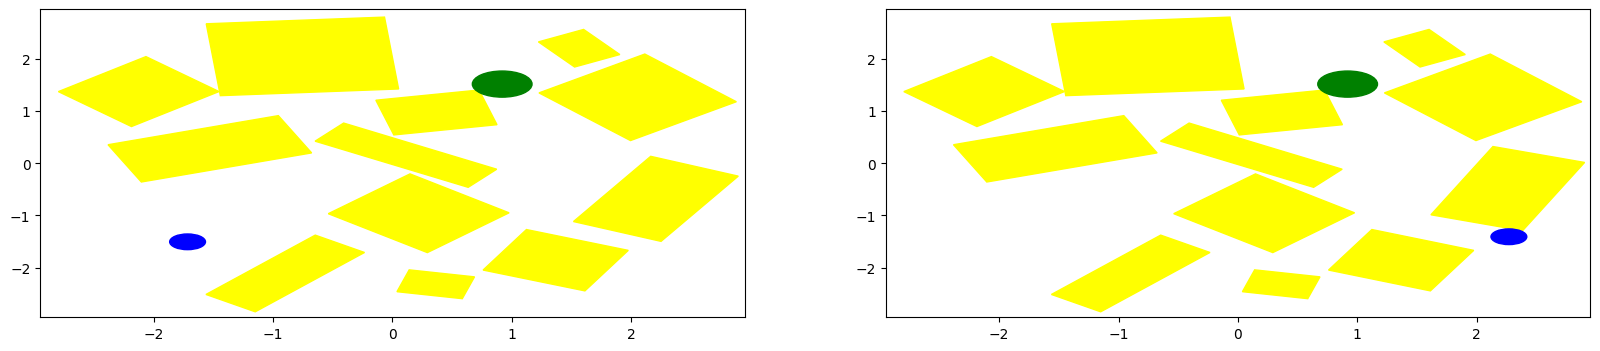

In [208]:
random.shuffle(final_datafiles)
dp_counts = {}
for datafile in [files for files in final_datafiles if "env_config_1342_" in files]:
    print(datafile)
    with open(datafile, "r") as f:
        data = json.load(f)
    if len(data['data_points']) > 2:
        break
config_name = data['config_name']
data_points = data['data_points']

geom_sizes = get_geom_sizes(data['config_name'])
fig, ax = plt.subplots(1, len(data_points), figsize=(20, 4))
for idx, dp in enumerate(data['data_points']):
    for objects, info in dp['state']['objects'].items():
        if objects in geom_sizes:
            rect_patch = create_rectange(*info['position'][:2], R.from_quat(info['quaternion'], scalar_first=True).as_euler('xyz')[-1], *geom_sizes[objects][:2], 'yellow')
            ax[idx].add_patch(rect_patch)
            
    circle_patch = create_circle(*dp['state']['robot']['position'][:2], 0.15, 'blue')
    ax[idx].add_patch(circle_patch)
    circle_patch = create_circle(*data['robot_goal'], 0.25, 'green')
    ax[idx].add_patch(circle_patch)
    ax[idx].set_xlim(-2.95, 2.95)
    ax[idx].set_ylim(-2.95, 2.95)
plt.show()

In [210]:
dp_counts = []
for datafile in tqdm(final_datafiles):
    with open(datafile, "r") as f:
        data = json.load(f)
    dp_counts.append(len(data['data_points']))

100%|██████████| 42203/42203 [00:28<00:00, 1457.73it/s]


In [227]:
from collections import Counter
subgoal_counts = 0
final_goal_counts = 0
for key, value in Counter(dp_counts).items():
    if key > 2 and key < 11:
        final_goal_counts += value
        subgoal_counts += (key - 2) * value
subgoal_counts, final_goal_counts, subgoal_counts + final_goal_counts

(15870, 10689, 26559)

KeysView(NpzFile '/common/users/dm1487/namo_data/images/jun6/random_start_random_goal_many_env/sequence_20250602_173153_fcbbda_env_config_9520_iter5_20250603_182522_ilab1.cs.rutgers.edu_0_dp000000.npz' with keys: scene, object_mask, goal_mask, reachable_objects_image)


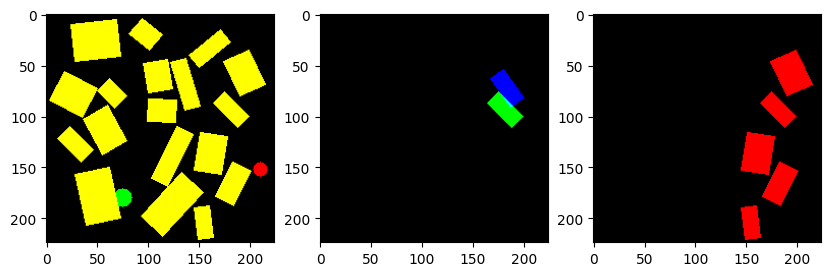

In [9]:
img_data = "/common/users/dm1487/namo_data/images/jun6/random_start_random_goal_many_env"
img_files = [f for f in os.listdir(img_data) if f.endswith('.npz')]
img_file = random.sample(img_files, 1)[0]

data = np.load(os.path.join(img_data, img_file))
print(data.keys())
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
sec = np.zeros_like(data['scene'])
sec[:, :, 1:2] = data['object_mask']
sec[:, :, 2:3] = data['goal_mask']
third = np.zeros_like(data['scene'])
third[:, :, 0] = data['reachable_objects_image'][:, :, 0]

ax[0].imshow(data['scene'])
ax[1].imshow(sec)
ax[2].imshow(third)
plt.show()

In [265]:
data.keys()

KeysView(NpzFile '/common/users/dm1487/namo_data/images/jun6/random_start_random_goal_many_env/sequence_20250602_172909_ce4f22_env_config_6009_iter3_20250604_165642_ilab1.cs.rutgers.edu_0_dp000001.npz' with keys: scene, object_mask, goal_mask, reachable_objects_image)